# <HR> SENTENCE TO SENTENCE SEMANTIC SIMILARITY <HR>
    Abstract: There are many methods available to compare words based on the context and the meaning, which convert the word into a representation in an n-dimensional vector space which is referred to as word embedding. Some of the methods are word2vec invented by Tomas Mikolov at Google, Glove from Stanford, and fastTest from Facebook. But, extending the notion of word similarity to complete sentence semantic similarity is one of the toughest problems in the Natural Language Processing(NLP). In this project, we build the system to compute the semantic similarity between two english sentences/questions using the Support Vector Machine(SVM). We consider the multiple similarities like literal similarity, shallow syntactic similarity, and latent semantic similarity as explanatory variables to predict the semantic similarity between two sentences. Our system predicts whether two sentences are duplicate or not based on the intent of the sentences.


### Load the Raipids cuML

In [2]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

### Import all required packages

In [3]:
import cudf, cuml
from cuml.svm import SVC

import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

import Levenshtein
from sklearn import metrics
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from gensim.models import LsiModel
import pickle
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.pyplot as plt
import warnings

In [4]:
warnings.filterwarnings('ignore') 

In [5]:
DATA_PATH = '/kaggle/input/'

### Load the Quora Question Pair dataset

In [6]:
data = pd.read_csv(DATA_PATH+'quora-question-pairs/train.csv.zip', index_col=['id'])
data = data.dropna()

### Train the TfidfVectorizer model

In [7]:
text_data = data.question1.append(data.question1)
model_Tfidf = TfidfVectorizer(lowercase=False).fit(text_data)
model_Tfidf = dict(zip(model_Tfidf.get_feature_names(), model_Tfidf.idf_))

### Load the pre-trained model Word2Vec

In [8]:
path = DATA_PATH+'googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin'
model_Word2Vec = KeyedVectors.load_word2vec_format(path, binary=True)  

### Methods to generate the features

In [9]:
def question2vec(question, preprocessor=None):
    question = question.split()
    sum_vec = np.array([model_Word2Vec[word] for word in question if word in model_Word2Vec and word in model_Tfidf])

    weights = np.array([(model_Tfidf[word]*question.count(word))/len(question) 
                        for word in question if word in model_Word2Vec and word in model_Tfidf])
    
    return np.average(sum_vec, axis=0, weights=weights) if sum(weights) else np.average(sum_vec, axis=0)

In [10]:
def preprocess(sentence):   
    pos_tag1 = nltk.pos_tag(nltk.word_tokenize(sentence), tagset='universal')
    pos_tag1 = set(map(lambda x: x[1], pos_tag1))
    return pos_tag1

In [11]:
def get_Levenshtein_distance(row):
    return Levenshtein.distance(row['question1'], row['question2'])

def cosine_similarity(row):
    vec1 = question2vec(row['question1'])
    vec2 = question2vec(row['question2'])
    if isinstance(vec1,np.float64) or isinstance(vec2,np.float64):
        return 0
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))

def jaccard_similarity(row, preprocessor=None):
    tokens1 = preprocessor(row['question1'])
    tokens2 = preprocessor(row['question2'])
    set1 = set(tokens1)
    set2 = set(tokens2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))    
    return 1.0 * len(w1&w2)/(len(w1)+len(w2))

### Generate different similarities features

In [12]:
data['jaccard_similarity'] = data.apply(jaccard_similarity, preprocessor=preprocess, axis=1)
data['word_share'] = data.apply(normalized_word_share, axis=1)
data['levenshtein_dst'] = data.apply(get_Levenshtein_distance, axis=1)
data['cosine_similarity'] = data.apply(cosine_similarity, axis=1)

In [13]:
data.to_csv('features.csv')

### Split the data into train set and test set

In [14]:
data = pd.read_csv(DATA_PATH+'similarities-features/features.csv')
X = data[['levenshtein_dst', 'cosine_similarity', 'jaccard_similarity', 'word_share']].to_numpy()
y = data['is_duplicate'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=2020)

### Train SVM model

In [15]:
model = SVC(kernel='rbf', C=10, gamma=1, cache_size=8000)
model.fit(X_train, y_train)

SVC(handle=<cuml.common.handle.Handle object at 0x7f691eb37d90>, C=10, kernel='rbf', degree=3, gamma=1, coef0=0.0, tol=0.001, cache_size=8000, max_iter=-1, nochange_steps=1000, verbose=False)

### Predict the Duplicate Question-Pair

In [16]:
y_pred = model.predict(X_test).to_array()

### Confusion Matrix of test set

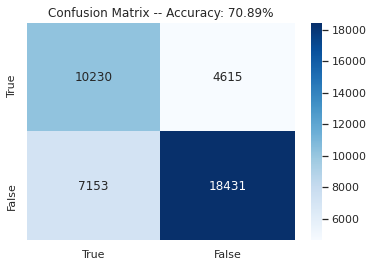

In [17]:
np.set_printoptions(precision=2)
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
df_cm = pd.DataFrame(cm, index = ['True', 'False'], columns = ['True', 'False'])
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap='Blues', fmt='d') # font size
plt.title('Confusion Matrix -- Accuracy: {}%'.format(metrics.accuracy_score(y_test, y_pred).round(4)*100))
plt.show()

### ROC-AUC Curve

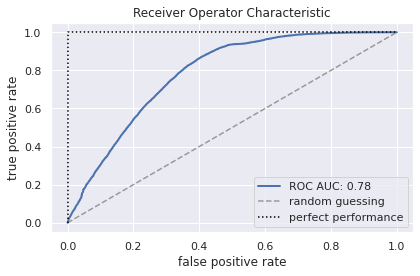

In [18]:
y_score = model.decision_function(X_test).to_array()

fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label = 1)

# AUC score that summarizes the ROC curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black', 
         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()